# Predict the Depth for Resnt-18 and Resnet-50

In [84]:
!unzip -qq /content/drive/MyDrive/MDE_Metrics/MetricsData.zip

replace MetricsData/Disparities/Resnet18/disparities.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace MetricsData/Disparities/Resnet18/disparities_pp.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [85]:
import numpy as np
from pathlib import Path

import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [175]:
def read_calib_file(path):
    # taken from https://github.com/hunse/kitti
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            #print(f"key: {key} value: {value} ")
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass
    return data

In [176]:
def get_focal_length_baseline(calib_dir, cam):
    cam2cam = read_calib_file(calib_dir + 'calib_cam_to_cam.txt')
    P2_rect = cam2cam['P_rect_02'].reshape(3,4)
    P3_rect = cam2cam['P_rect_03'].reshape(3,4)

    # cam 2 is left of camera 0  -6cm
    # cam 3 is to the right  +54cm
    b2 = P2_rect[0,3] / -P2_rect[0,0]
    b3 = P3_rect[0,3] / -P3_rect[0,0]
    baseline = b3-b2

    if cam==2:
        focal_length = P2_rect[0,0]
    elif cam==3:
        focal_length = P3_rect[0,0]

    return focal_length, baseline

In [177]:
calib_dir, camera_id_2, camera_id_3 = "/content/", 2, 3
focal_length_2, baseline_2 = get_focal_length_baseline(calib_dir, camera_id_2)
focal_length_3, baseline_3 = get_focal_length_baseline(calib_dir, camera_id_3)
focal_length_2, focal_length_3, baseline_2, baseline_3

(721.5377, 721.5377, 0.5327254279298227, 0.5327254279298227)

In [178]:
TEST_TRN = "/content/MetricsData/TestImages/2011_09_26_drive_0001_sync"
TEST_VAL = "/content/MetricsData/TestImages/2011_09_26_drive_0020_sync"
GNDT_TRN = "/content/MetricsData/GroundTruth/train/2011_09_26_drive_0001_sync"
GNDT_VAL = "/content/MetricsData/GroundTruth/val/2011_09_26_drive_0020_sync"
DISP18 = "/content/MetricsData/Disparities/Resnet18"
DISP50 = "/content/MetricsData/Disparities/Resnet50"

In [179]:
def display_image(timage=None, dispm=None, imgi=0):
    plt.figure(figsize=(20,15))
    img = np.asarray(Image.open(timage).resize((512,256)))
    itit = str(img.shape) + "   " + str(timage).split('/')[-1]
    plt.title(itit)
    plt.xlabel("Width ------> ")
    plt.ylabel("Height ------> ")
    plt.grid(True, which='major', color='r', linestyle='-')
    plt.grid(visible=True, which='minor',  axis='x', color='y', linestyle='-')
    plt.grid(visible=True, which='minor',  axis='y', color='b', linestyle='-')
    plt.minorticks_on()
    plt.imshow(img)
    print("Farest object: %5.3f  Nearest object: %5.3f meter" 
          %(get_depth(dispm[imgi].min()),  get_depth( dispm[imgi].max())))

In [180]:
def show_distance(dispm=None, imgi=None, w_coords=None):
    print(f"Width: and various Height (00 to 250):(meter : feet):")
    print("----------------------------------------------------",end="")
    for w_coord in w_coords:
      print(f"\nWidth:{w_coord}:-\nHeight:",end="")
      for y in range(250,0,-10):
        met = get_depth(dispm[imgi][y][w_coord])
        print("%d::(%4.2f:%4.2f)" %(y, met, met*3.28), end=", ")
    print()

In [181]:
def get_depth(disparity):
  return (focal_length_2 *1e-3 * baseline_2) / disparity

In [182]:
def depth_diff(gtdepth=None, pdepth=None):
  print("Ground Truth: %4.2f, Pred: %4.2f, Difference: %4.2f" %( gtdepth, pdepth,  pdepth - gtdepth ))

# **Estimate the depth for Restnet-18**

In [183]:
disp18 = np.load(Path(DISP18) / "disparities.npy")
print("Resnet-18: Farest object: %5.3f  Nearest object: %5.3f meter" 
      %(get_depth(disp18.min()),  get_depth( disp18.max())))
disp18.min(), disp18.max()

Resnet-18: Farest object: 6.909  Nearest object: 1.744 meter


(0.055636976, 0.22037114)

In [184]:
image70 = Path(TEST_VAL) / "0000000070.png"
image79 = Path(TEST_VAL) / "0000000079.png"
image90 = Path(TEST_TRN) / "0000000090.png"

gt_image70 = Path(GNDT_VAL) / "0000000070.png"
gt_image79 = Path(GNDT_VAL) / "0000000079.png"

Farest object: 6.620  Nearest object: 1.775 meter
Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:160:-
Height:250::(2.75:9.02), 240::(3.22:10.56), 230::(3.08:10.11), 220::(2.94:9.66), 210::(3.05:10.01), 200::(3.11:10.22), 190::(2.87:9.41), 180::(2.79:9.14), 170::(2.93:9.63), 160::(3.19:10.46), 150::(3.38:11.08), 140::(3.34:10.96), 130::(3.41:11.17), 120::(3.31:10.84), 110::(3.23:10.59), 100::(3.20:10.49), 90::(3.09:10.13), 80::(3.03:9.93), 70::(3.00:9.84), 60::(3.02:9.90), 50::(3.06:10.03), 40::(2.95:9.66), 30::(2.71:8.88), 20::(2.99:9.79), 10::(3.23:10.60), 
Width:180:-
Height:250::(2.69:8.83), 240::(3.10:10.18), 230::(2.98:9.79), 220::(2.92:9.57), 210::(2.88:9.46), 200::(2.69:8.81), 190::(2.63:8.64), 180::(2.85:9.35), 170::(2.78:9.12), 160::(2.93:9.61), 150::(2.53:8.30), 140::(2.50:8.22), 130::(2.83:9.28), 120::(2.77:9.09), 110::(2.63:8.62), 100::(2.56:8.40), 90::(2.64:8.67), 80::(2.52:8.27), 70::(2.48:8.12), 60::(2.63

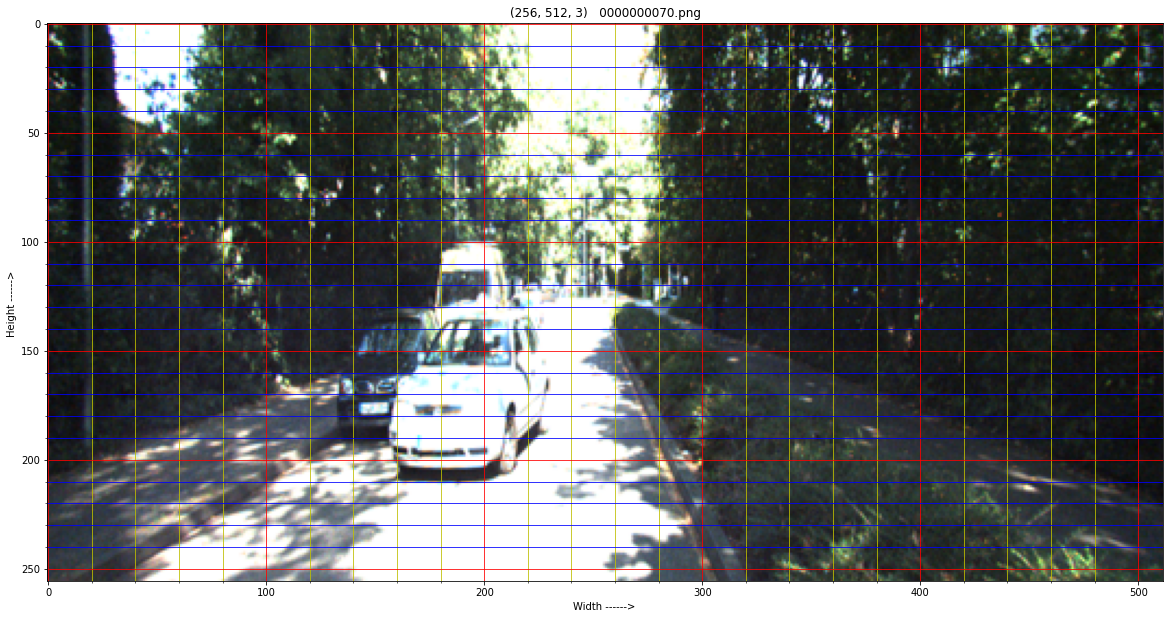

In [185]:
display_image(timage=image70, dispm=disp18, imgi=0)
show_distance(dispm=disp18, imgi=0, w_coords=[160, 180, 200])

Farest object: 6.492  Nearest object: 1.773 meter


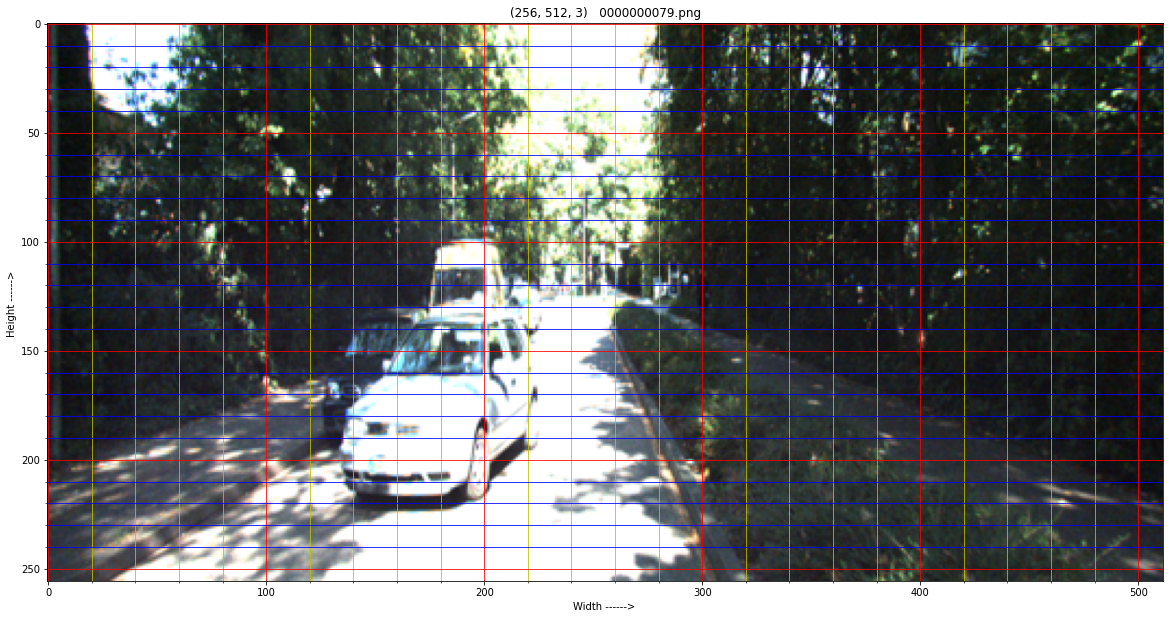

In [186]:
display_image(timage=image79, dispm=disp18, imgi=9)

In [187]:
show_distance(dispm=disp18, imgi=9, w_coords=[140,160, 180, 200])

Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:140:-
Height:250::(3.01:9.86), 240::(3.41:11.20), 230::(3.43:11.26), 220::(3.24:10.62), 210::(3.29:10.78), 200::(3.01:9.87), 190::(3.18:10.43), 180::(3.25:10.65), 170::(3.29:10.79), 160::(3.71:12.18), 150::(3.76:12.33), 140::(3.69:12.09), 130::(3.69:12.11), 120::(3.72:12.21), 110::(3.73:12.22), 100::(3.64:11.95), 90::(3.52:11.56), 80::(3.47:11.38), 70::(3.47:11.37), 60::(3.39:11.12), 50::(3.39:11.12), 40::(3.32:10.90), 30::(3.24:10.62), 20::(3.31:10.86), 10::(3.57:11.72), 
Width:160:-
Height:250::(2.85:9.36), 240::(3.46:11.34), 230::(3.24:10.64), 220::(3.04:9.98), 210::(2.74:9.00), 200::(2.78:9.12), 190::(2.88:9.45), 180::(2.82:9.26), 170::(2.92:9.56), 160::(3.27:10.73), 150::(3.12:10.25), 140::(3.26:10.69), 130::(3.28:10.77), 120::(3.36:11.01), 110::(3.33:10.91), 100::(3.29:10.78), 90::(3.23:10.59), 80::(3.10:10.16), 70::(3.00:9.83), 60::(3.07:10.07), 50::(3.05:10.02), 40::

Farest object: 6.530  Nearest object: 1.799 meter
Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:260:-
Height:250::(3.69:12.09), 240::(4.24:13.92), 230::(3.79:12.44), 220::(3.52:11.53), 210::(3.59:11.76), 200::(3.73:12.23), 190::(3.48:11.41), 180::(3.32:10.88), 170::(2.77:9.10), 160::(2.65:8.69), 150::(2.55:8.36), 140::(2.47:8.09), 130::(2.40:7.87), 120::(2.26:7.43), 110::(1.99:6.54), 100::(2.01:6.58), 90::(2.11:6.93), 80::(2.18:7.17), 70::(2.27:7.45), 60::(2.33:7.66), 50::(2.36:7.73), 40::(2.40:7.89), 30::(2.39:7.83), 20::(2.53:8.29), 10::(2.71:8.90), 
Width:500:-
Height:250::(3.43:11.25), 240::(3.44:11.29), 230::(3.41:11.19), 220::(3.55:11.65), 210::(3.50:11.48), 200::(3.59:11.76), 190::(3.52:11.56), 180::(3.40:11.17), 170::(3.38:11.07), 160::(3.38:11.08), 150::(3.48:11.41), 140::(3.42:11.23), 130::(3.36:11.01), 120::(3.56:11.67), 110::(3.25:10.68), 100::(3.16:10.36), 90::(3.84:12.59), 80::(4.15:13.61), 70::(4.22:13.84

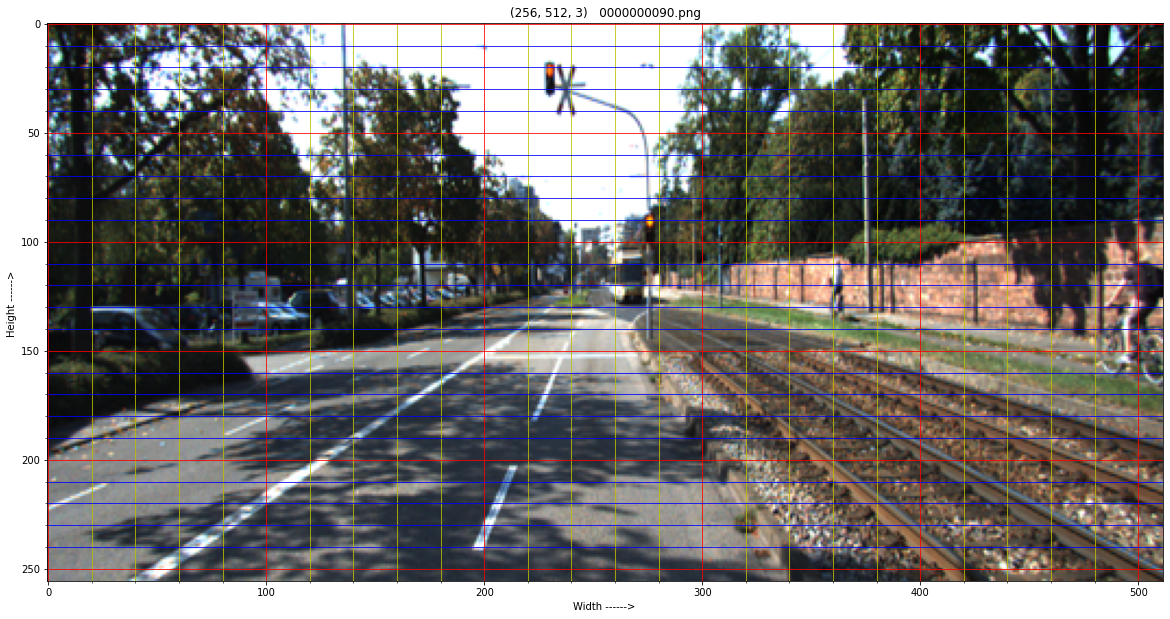

In [188]:
display_image(timage=image90, dispm=disp18, imgi=10)
show_distance(dispm=disp18, imgi=10, w_coords=[260, 500, 510])

# **Estimate the depth for Restnet-50**


In [189]:
disp50 = np.load(Path(DISP50) /"disparities.npy")
print("Resnet-50: Farest object: %5.3f  Nearest object: %5.3f meter" 
      %(get_depth(disp50.min()),  get_depth( disp50.max())))
disp50.min(), disp50.max()

Resnet-50: Farest object: 9.620  Nearest object: 1.566 meter


(0.03995496, 0.24547537)

Farest object: 7.718  Nearest object: 1.566 meter


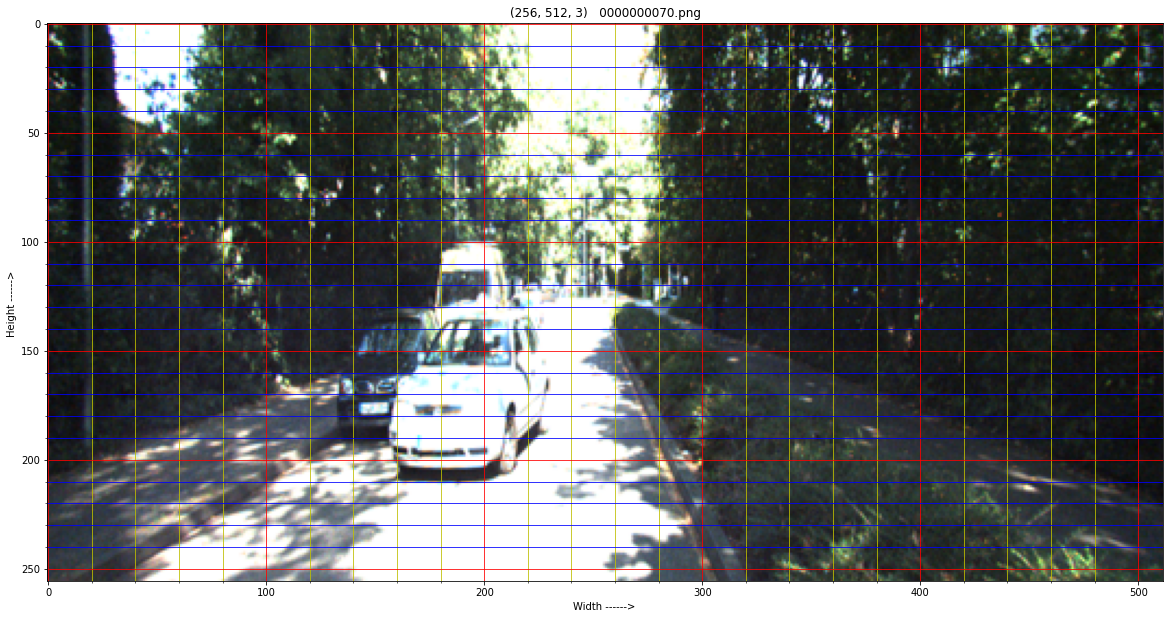

In [190]:
display_image(timage=image70, dispm=disp50, imgi=0)

In [191]:
show_distance(dispm=disp50, imgi=0, w_coords=[160, 180, 200])

Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:160:-
Height:250::(2.00:6.56), 240::(1.77:5.82), 230::(1.74:5.71), 220::(1.78:5.84), 210::(2.02:6.63), 200::(1.93:6.32), 190::(1.79:5.86), 180::(1.75:5.73), 170::(1.95:6.38), 160::(2.64:8.67), 150::(2.64:8.67), 140::(3.23:10.60), 130::(3.87:12.71), 120::(4.18:13.72), 110::(4.54:14.88), 100::(4.91:16.09), 90::(5.06:16.61), 80::(4.65:15.24), 70::(4.63:15.17), 60::(4.75:15.59), 50::(4.71:15.46), 40::(4.73:15.53), 30::(4.17:13.68), 20::(4.48:14.69), 10::(4.32:14.17), 
Width:180:-
Height:250::(1.96:6.42), 240::(1.74:5.71), 230::(1.73:5.69), 220::(1.71:5.62), 210::(2.38:7.81), 200::(1.85:6.08), 190::(1.68:5.52), 180::(1.87:6.12), 170::(1.74:5.70), 160::(1.95:6.40), 150::(2.15:7.05), 140::(1.96:6.43), 130::(2.75:9.01), 120::(3.00:9.83), 110::(2.50:8.18), 100::(3.96:13.00), 90::(4.15:13.62), 80::(4.12:13.51), 70::(3.74:12.26), 60::(4.33:14.21), 50::(3.93:12.90), 40::(4.03:13.21), 30

In [192]:
print("Comparing with Resnet-18, distance predictions.")
show_distance(dispm=disp18, imgi=0, w_coords=[200])

Comparing with Resnet-18, distance predictions.
Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:200:-
Height:250::(2.68:8.78), 240::(3.04:9.99), 230::(2.93:9.61), 220::(2.83:9.29), 210::(2.78:9.13), 200::(2.69:8.82), 190::(2.57:8.43), 180::(2.63:8.62), 170::(2.64:8.66), 160::(2.74:8.98), 150::(2.54:8.33), 140::(2.40:7.87), 130::(2.37:7.78), 120::(2.35:7.72), 110::(2.18:7.16), 100::(2.32:7.60), 90::(2.22:7.27), 80::(2.17:7.10), 70::(2.20:7.21), 60::(2.32:7.61), 50::(2.23:7.31), 40::(2.21:7.26), 30::(2.27:7.43), 20::(2.32:7.59), 10::(2.62:8.59), 


Farest object: 7.914  Nearest object: 1.589 meter


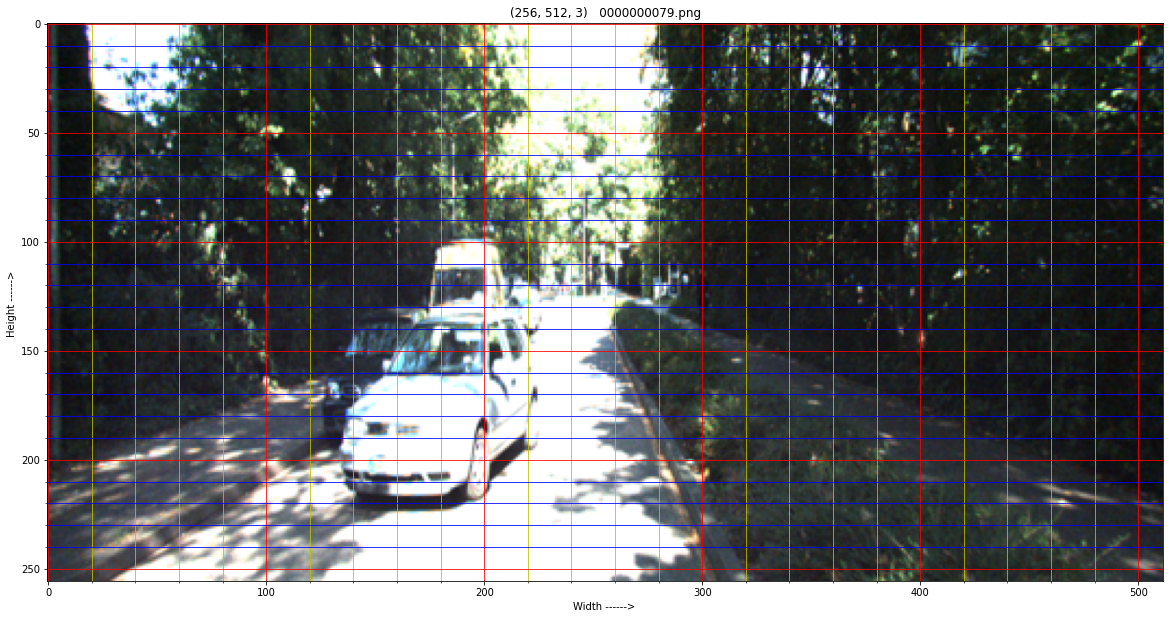

In [193]:
display_image(timage=image79, dispm=disp50, imgi=9)

In [195]:
show_distance(dispm=disp50, imgi=9, w_coords=[160, 180, 200])

Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:160:-
Height:250::(1.99:6.54), 240::(1.79:5.87), 230::(1.91:6.28), 220::(2.14:7.02), 210::(1.78:5.82), 200::(1.76:5.76), 190::(1.89:6.19), 180::(1.82:5.96), 170::(1.81:5.95), 160::(2.14:7.00), 150::(2.63:8.62), 140::(2.89:9.49), 130::(3.55:11.63), 120::(3.87:12.71), 110::(3.95:12.95), 100::(4.29:14.06), 90::(4.43:14.51), 80::(4.32:14.18), 70::(4.15:13.61), 60::(4.32:14.18), 50::(4.35:14.27), 40::(4.31:14.13), 30::(4.48:14.68), 20::(4.13:13.55), 10::(4.12:13.53), 
Width:180:-
Height:250::(1.98:6.50), 240::(1.77:5.82), 230::(1.76:5.78), 220::(1.98:6.51), 210::(1.87:6.15), 200::(1.69:5.53), 190::(1.73:5.67), 180::(1.76:5.79), 170::(1.74:5.72), 160::(2.22:7.29), 150::(2.10:6.90), 140::(1.97:6.45), 130::(2.39:7.85), 120::(2.69:8.81), 110::(1.96:6.43), 100::(3.42:11.20), 90::(3.68:12.06), 80::(3.61:11.83), 70::(3.42:11.22), 60::(3.96:12.99), 50::(3.63:11.92), 40::(3.32:10.90), 30:

Farest object: 9.329  Nearest object: 1.633 meter


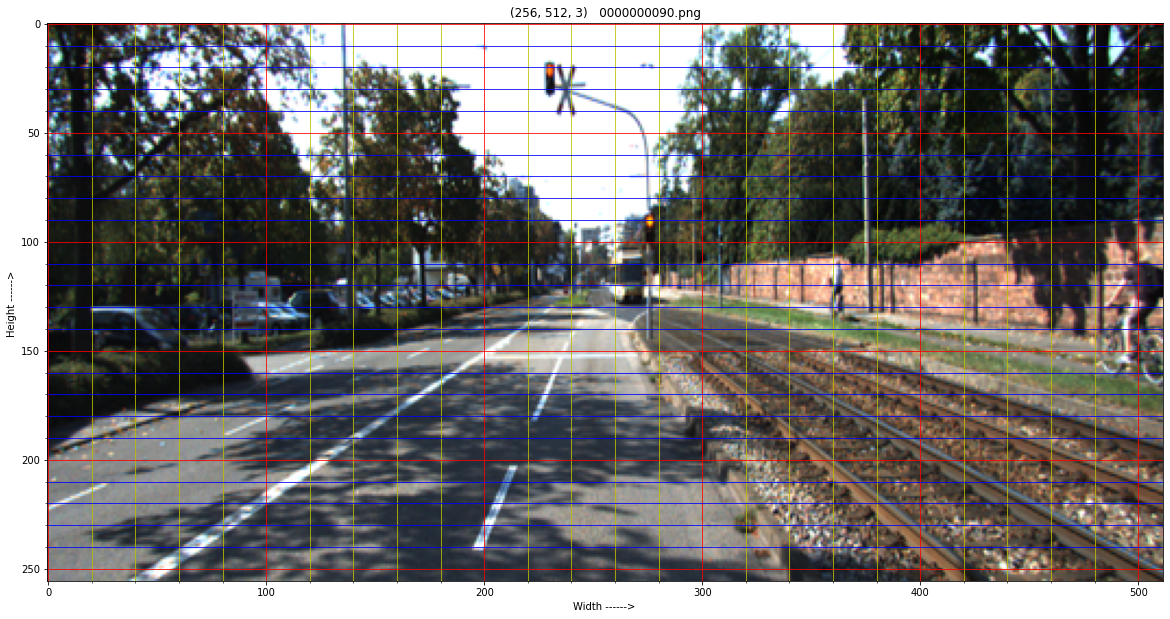

In [196]:
display_image(timage=image90, dispm=disp50, imgi=10)

In [197]:
show_distance(dispm=disp50, imgi=10, w_coords=[260, 500, 510])

Width: and various Height (00 to 250):(meter : feet):
----------------------------------------------------
Width:260:-
Height:250::(3.76:12.32), 240::(2.48:8.12), 230::(2.41:7.91), 220::(2.30:7.53), 210::(2.64:8.67), 200::(3.17:10.40), 190::(2.78:9.13), 180::(2.95:9.69), 170::(2.30:7.54), 160::(2.17:7.10), 150::(2.23:7.31), 140::(2.27:7.46), 130::(3.29:10.79), 120::(3.22:10.55), 110::(2.76:9.05), 100::(2.79:9.14), 90::(2.38:7.82), 80::(2.22:7.28), 70::(2.21:7.25), 60::(2.13:6.98), 50::(2.03:6.66), 40::(1.93:6.34), 30::(1.80:5.91), 20::(1.77:5.79), 10::(1.73:5.66), 
Width:500:-
Height:250::(3.52:11.55), 240::(2.95:9.69), 230::(2.87:9.43), 220::(3.25:10.67), 210::(2.82:9.25), 200::(3.47:11.37), 190::(2.83:9.27), 180::(3.11:10.21), 170::(3.07:10.05), 160::(2.92:9.57), 150::(3.07:10.06), 140::(2.95:9.68), 130::(2.74:8.98), 120::(3.36:11.01), 110::(2.78:9.11), 100::(3.52:11.54), 90::(4.66:15.30), 80::(5.29:17.35), 70::(5.45:17.87), 60::(5.28:17.33), 50::(4.81:15.79), 40::(5.22:17.11), 30::(

# Ground Truth

**Ground Truth distance(s)  (375, 1242)**

In [198]:
def get_GT_depth(image=None):
    img = np.asarray(Image.open(image)) #Jag: .resize((512,256)))
    gtd_ = img.astype(np.float32) / 256
    return gtd_

In [199]:
gtdisp79 = get_GT_depth(image=gt_image79)
gtdisp79.shape

(375, 1242)

**Ground Truth Image (375, 1242)**

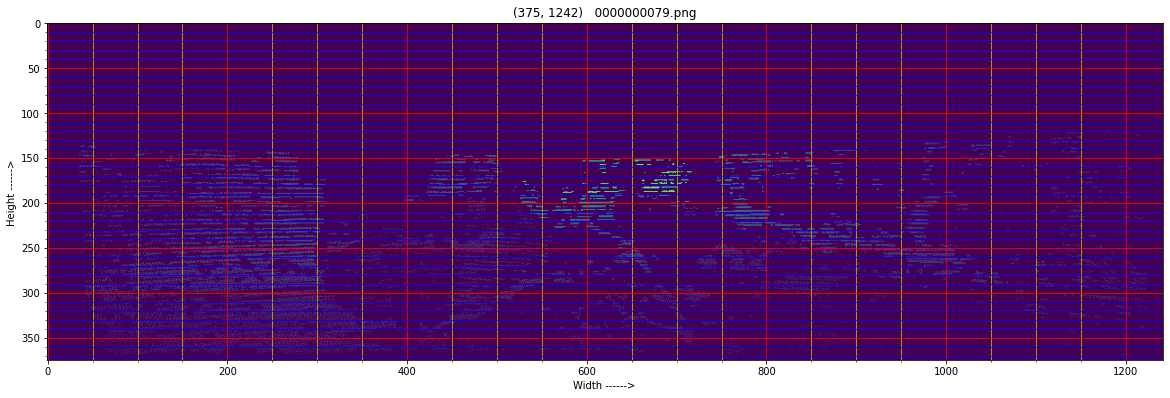

In [200]:
plt.figure(figsize=(20,15))
img = np.asarray(Image.open(gt_image79))
itit = (str(img.shape)) + "   " + str(gt_image79).split('/')[-1]
plt.title(itit)
plt.xlabel("Width ------> ")
plt.ylabel("Height ------> ")
plt.grid(True, which='major', color='r', linestyle='-')
plt.grid(visible=True, which='minor',  axis='x', color='y', linestyle='-')
plt.grid(visible=True, which='minor',  axis='y', color='b', linestyle='-')
plt.minorticks_on()
plt.imshow(img)

In [201]:
gtdisp79.min(), gtdisp79.max()

(0.0, 79.140625)